In [18]:
%matplotlib notebook
import numpy as np
import scipy as sp
from utils import functions_2D as F2D
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.style.use(r'utils/mplstyle')

In [19]:
# nice colours to use

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fb9d32', '#fec787']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [20]:
# generate a random 2D disk and check the shape is concave

seed = 219
std = 0.12
num_modes = 3 # the sum over modes runs from 2 to num_modes + 2


# r is a function r(order, φ)
# where order is the order of differentiation, 
# and φ is the polar angle of the contact point
r, A = F2D.get_r(seed, num_modes = num_modes, std = std)

# test whether the realisation is convex
# if the shape is concave, this prints a message
# test_r returns True/False
convex = F2D.test_r(r)

In [21]:
# calculate critical angle alpha^*

THETA = np.linspace(0, 2 * np.pi, 1000)
THETA = np.append(THETA, 0)

r0 = r(0, THETA)
r1 = r(1, THETA)
q = (r1 / r0)
Q = max(q)
tStar = THETA[np.argmax(q)]
p = THETA[np.argmax(q)]
alphaStar = np.arctan(Q)

In [22]:
m = 10 # mass

In [23]:
# simulate just above the critical angle

s0 = [p, 0]
ti = 0
tf = 2000
outputN = 2000

a = alphaStar + 0.0001
res = sp.integrate.solve_ivp(F2D.propagate, (ti, tf), s0, t_eval = np.linspace(ti, tf, outputN), args = (a, m, r), method = 'RK45')

s = res.y
t = res.t

<IPython.core.display.Javascript object>


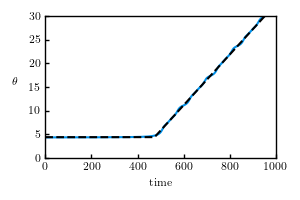

In [24]:
plt.figure(figsize = (3,2))
plt.plot(t, s[0], color = colors[0][1])
popt, pcov = curve_fit(F2D.fit_fn, t, s[0], p0 = (300, 0.1, p))
plt.plot(t, F2D.fit_fn(t, *popt), zorder = 10, color = 'black', linestyle = 'dashed')
plt.xlim(0, 1000)
plt.ylim(0, 30)
plt.xlabel('time')
plt.ylabel(r'$\theta$', rotation = 0, labelpad = 10)
plt.tight_layout()
plt.show()
plt.savefig('2DPlots/inertia_single.pdf')

In [25]:
# simulate hysteresis

In [26]:
# ramp angle increases from criticality, then decreases
Dalpha= np.append([0], np.logspace(-5, -2, 20)[:-1])
Dalpha = np.append(Dalpha, np.linspace(0.01, 0.2 - alphaStar, 20))
alpha = alphaStar + Dalpha
alpha = [*alpha, *np.linspace(alpha[-1], alphaStar, 15)[1:]]
alpha = [*alpha, *np.linspace(alpha[-1], 0.055, 30)[1:]] # zoom into a small regi
alpha = [*alpha, *np.linspace(alpha[-1], 0.045, 40)[1:], 0]

In [27]:
s00 = [p, 0]
S = np.zeros((len(alpha), outputN))

for i in range(len(alpha) - 1):
    a = alpha[i + 1]
    print(i, end = '\r')
    res = sp.integrate.solve_ivp(F2D.propagate,
                                 (ti, tf), s00,
                                 t_eval = np.linspace(ti, tf, outputN),
                                 args = (a, m, r),
                                 method = 'RK23')
    s = res.y
    t = res.t
    s00 = s[:, -1]
    S[i + 1] = s[0]

In [28]:
angVel = [0]
for i in range(len(S) - 1):
    s = S[i + 1]
    popt, pcov = curve_fit(F2D.fit_fn, t, s, p0 = (30, 0.1, s[0]))
    angVel.append(popt[1])

In [29]:
# simulate massless case
angVel_0 = [0]
Dalpha_0 = np.append([0], np.logspace(-5, -2, 20)[:-1])
Dalpha_0 = np.append(Dalpha_0, np.linspace(0.01, 0.2 - alphaStar, 20))

for i in range(len(Dalpha_0) - 1):
    a = alphaStar + Dalpha_0[i + 1]
    res = sp.integrate.quad(F2D.dtdθ, 0, 2 * np.pi, args = (r, a))
    angVel_0.append(np.pi * 2 / res[0])

<IPython.core.display.Javascript object>


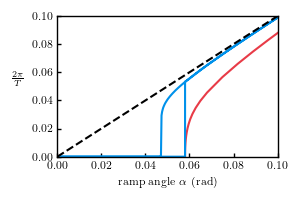

In [30]:
plt.figure(figsize = (3, 2))
plt.plot(alphaStar + Dalpha_0, angVel_0, color = colors[1][1])
plt.plot([0, *alpha], [0, *angVel], color = colors[0][1])

ideal = np.linspace(0, 1, 1000)

plt.plot(ideal, np.sin(ideal), color = 'black', linestyle = 'dashed')
plt.xlabel(r'ramp angle $\alpha$ (rad)')
plt.ylabel(r'$\frac{2\pi}{T}$', rotation = 0, labelpad = 10)
plt.ylim(0, 0.10)
plt.xlim(0, 0.10)
plt.tight_layout()
plt.savefig('2DPlots/inertia_hysteresis_transition.pdf')

In [31]:
# hysteresis transition in phase space
s0 = [1, 0.04]
aS = [0.07, alphaStar, 0.05, 0.040, 0.030, 0.020]

# generate simulation trajectories
SIM_RES = []
for a in aS:
    res = sp.integrate.solve_ivp(F2D.propagate, (0, 500), s0,
                                 t_eval = np.linspace(0, 500, outputN),
                                 args = (a, m, r), method = 'RK23')
    s = res.y
    t = res.t
    
    SIM_RES.append([s, t])

In [32]:
# setup flow diagrams

t0 = np.linspace(0, 2 * np.pi, 50)
t1 = np.linspace(-0.02, 0.12, 50)

T0, T1 = np.meshgrid(t0, t1)

FLO_RES = []

for a in aS:
    U = np.zeros(T0.shape)
    V = np.zeros(T0.shape)

    # Compute the vectors at each point in s
    for i in range(len(T0)):
        for j in range(len(T0[0])):

            vector = F2D.propagate(0, [T0[i][j], T1[i][j]], a, m, r)
            U[i][j] = vector[0]
            V[i][j] = vector[1]
    FLO_RES.append([U, V])

<IPython.core.display.Javascript object>


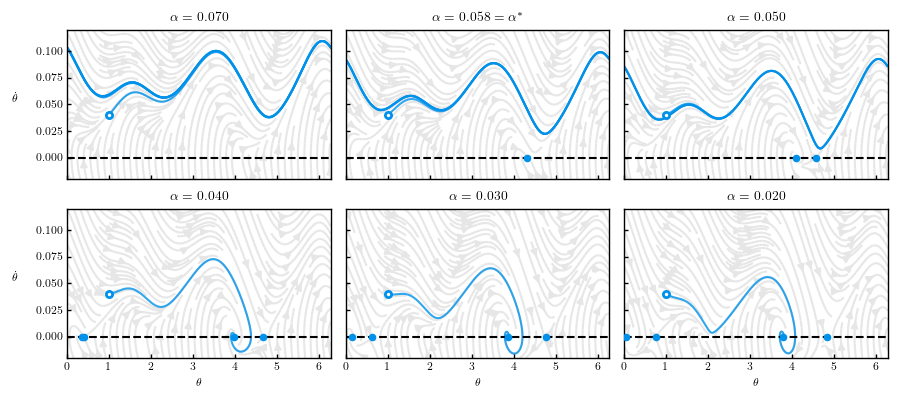

In [33]:
fig, axes = plt.subplots(2, 3, figsize = (9, 4), sharex = True, sharey = True)
axes = np.reshape(axes, -1)

for i in range(6):
    
    [s, t] = SIM_RES[i]
    [U, V] = FLO_RES[i]
    if i == 1:
        axes[i].set_title(r'$\alpha={0:.3f}=\alpha^*$'.format(aS[i]))
    else:
        axes[i].set_title(r'$\alpha={0:.3f}$'.format(aS[i]))
    
    chunk_num = s[0] // (2 * np.pi)
    for _ in list(set(chunk_num)):
        mask = (chunk_num == _)
        axes[i].plot(s[0][mask] % (2 * np.pi), s[1][mask], color = colors[0][1], alpha = 0.8, zorder = 1)
    
    axes[i].scatter([1], [0.04], facecolor = 'white', edgecolor = colors[0][1], s = 20, lw = 2, zorder = 20)
    axes[i].streamplot(T0, T1, U, V, density = 1.4, color = (0.9, 0.9, 0.9), zorder = -10) 
    
    axes[i].axhline(0, linestyle = 'dashed', color = 'black')
    
    if i == 1:
        axes[i].scatter([tStar], [0], color = colors[0][1], s = 20, zorder = 10000)
    
    if aS[i] < alphaStar:
        tana = np.tan(aS[i])
        _t = np.linspace(0, 2 * np.pi, 1000)
        _r0 = r(0, _t)
        _r1 = r(1, _t)
        _y = _r1 / _r0 - tana
        _sign = (_y > 0).astype(int)
        _diff = np.diff(_sign)
        
        change_indices = np.where(_diff != 0)[0] + 1
        
        axes[i].scatter(_t[change_indices], np.zeros(len(change_indices)), color = colors[0][1], s = 20, zorder = 10)
    
axes[0].set_xlim(0, 2 * np.pi)
axes[0].set_ylim(-0.02, 0.12)

for i in [3, 4, 5]:
    axes[i].set_xlabel(r'$\theta$')
for i in [0, 3]:
    axes[i].set_ylabel(r'$\dot{\theta}$', rotation = 0, labelpad = 15)
plt.tight_layout()
plt.show()
plt.savefig('2DPlots/inertia_hysteresis_flow.pdf')

In [34]:
# get lag times for the first-order transition

seeds = [0, 1, 2, 3, 4]
Ms = [0.5, 2, 10]
std = 0.12
num_modes = 3

ti = 0
tf = 2000
outputN = 1000

Dalpha = np.logspace(-5, -2, 20)

RES = np.zeros((len(seeds), len(Ms), len(Dalpha)))
for i, seed in enumerate(seeds):
    
    r, A = F2D.get_r(seed, num_modes = num_modes, std = std)
    if F2D.test_r(r):
        
        # calculate critical angle alpha^*
        r0 = r(0, THETA)
        r1 = r(1, THETA)
        q = (r1 / r0)
        Q = max(q)
        tStar = THETA[np.argmax(q)]
        p = THETA[np.argmax(q)]
        alphaStar = np.arctan(Q)
        s0 = [p, 0.00] # initial condition for simulation
        
        for j, m in enumerate(Ms):
            for k, da in enumerate(Dalpha):
                print('{0:02d}-{1:02d}-{2:02d}'.format(i,j,k), end = '\r')
                
                a = alphaStar + da
                res = sp.integrate.solve_ivp(F2D.propagate,
                                             (ti, tf), s0,
                                             t_eval = np.linspace(ti, tf, outputN),
                                             args = (a, m, r),
                                             method = 'RK23')
                s = res.y
                t = res.t
                popt, pcov = curve_fit(F2D.fit_fn, t, s[0], p0 = (30, 0.1, p))

                RES[i,j,k] = popt[0]

<IPython.core.display.Javascript object>


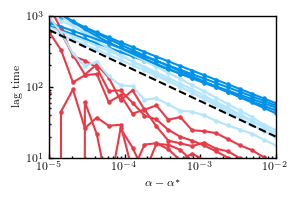

In [35]:
plt.figure(figsize = (3, 2))

ccs = [colors[1][1], colors[0][0], colors[0][1]]

for i, seed in enumerate(seeds):
    for j, m in enumerate(Ms):
        plt.scatter(Dalpha, RES[i,j], c = ccs[j], s = 5)
        plt.plot(Dalpha, RES[i,j], c = ccs[j])

plt.plot(Dalpha, 2 * Dalpha ** (-1/2), color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5, 1e-2)
plt.ylim(1e1, 1e3)

plt.xlabel(r'$\alpha-\alpha^{*}$')
plt.ylabel('lag time')

plt.tight_layout()
plt.show()
plt.savefig('2DPlots/inertia_lagtime.pdf')